# Advanced Feature Engineering in BQML

**Learning Objectives**

1. Evaluate the model
2. Extract temporal features, feature cross temporal features
3. Apply `ML.FEATURE_CROSS` to categorical features
4. Create a Euclidian feature column, feature cross coordinate features
5. Apply the `BUCKETIZE` function, `TRANSFORM` clause, L2 Regularization


## Overview 
In this lab, we utilize feature engineering to improve the prediction of the fare amount for a taxi ride in New York City.  We will use BigQuery ML to build a taxifare prediction model, using feature engineering to improve and create a final model. By continuing the utilization of feature engineering to improve the prediction of the fare amount for a taxi ride in New York City by reducing the RMSE.

In this Notebook, we perform a feature cross using BigQuery's `ML.FEATURE_CROSS`, derive coordinate features, feature cross coordinate features, clean up the code, apply the `BUCKETIZE` function, the `TRANSFORM` clause, L2 Regularization, and evaluate model performance throughout the process.

In [1]:
PROJECT = !gcloud config get-value project
PROJECT = PROJECT[0]

%env PROJECT=$PROJECT

env: PROJECT=qwiklabs-asl-01-1d0b6cba208c


## The source dataset

Our dataset is hosted in [BigQuery](https://cloud.google.com/bigquery/). The taxi fare data is a publically available dataset, meaning anyone with a GCP account has access. Click [here](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=nyc-tlc&d=yellow&t=trips&page=table) to access the dataset.

The Taxi Fare dataset is relatively large at 55 million training rows, but simple to understand, with only six features. The fare_amount is the target, the continuous value we’ll train a model to predict.


## Create a BigQuery Dataset

A BigQuery dataset is a container for tables, views, and models built with BigQuery ML. Let's create one called __feat_eng__ if we have not already done so in an earlier lab. We'll do the same for a GCS bucket for our project too.

In [2]:
%%bash

# Create a BigQuery dataset for feat_eng if it doesn't exist
datasetexists=$(bq ls -d | grep -w feat_eng)

if [ -n "$datasetexists" ]; then
    echo -e "BigQuery dataset already exists, let's not recreate it."

else
    echo "Creating BigQuery dataset titled: feat_eng"
    
    bq --location=US mk --dataset \
        --description 'Taxi Fare' \
        $PROJECT:feat_eng
    echo "\nHere are your current datasets:"
    bq ls
fi    

Creating BigQuery dataset titled: feat_eng
Dataset 'qwiklabs-asl-01-1d0b6cba208c:feat_eng' successfully created.
\nHere are your current datasets:
   datasetId    
 -------------- 
  feat_eng      
  serverlessml  


## Create the training data table

Since there is already a publicly available dataset, we can simply create the training data table using this raw input data.  Note the WHERE clause in the below query:  This clause allows us to TRAIN a portion of the data (e.g. one hundred thousand rows versus one million rows), which keeps your query costs down.  If you need a refresher on using MOD() for repeatable splits see this [post](https://www.oreilly.com/learning/repeatable-sampling-of-data-sets-in-bigquery-for-machine-learning).  

* Note:  The dataset in the create table code below is the one created previously, e.g. `feat_eng`.  The table name is `feateng_training_data`.  Run the query to create the table.

In [3]:
%%bigquery
CREATE OR REPLACE TABLE
  feat_eng.feateng_training_data AS
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  passenger_count*1.0 AS passengers,
  pickup_datetime,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat
FROM
  `nyc-tlc.yellow.trips`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 10000) = 1
  AND fare_amount >= 2.5
  AND passenger_count > 0
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45

Query complete after 0.01s: 100%|██████████| 3/3 [00:00<00:00, 1475.66query/s]                        


""


## Verify table creation

Verify that you created the dataset.


In [4]:
%%bigquery

# LIMIT 0 is a free query; this allows us to check that the table exists.
SELECT
*
FROM
  feat_eng.feateng_training_data
LIMIT
  0

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 318.84query/s]                          
Downloading: 0rows [00:00, ?rows/s]


,fare_amount,passengers,pickup_datetime,pickuplon,pickuplat,dropofflon,dropofflat


### Baseline Model:  Create the baseline model

Next, you create a linear regression baseline model with no feature engineering.  Recall that a model in BigQuery ML represents what an ML system has learned from the training data.  A baseline model is a solution to a problem without applying any machine learning techniques.  

When creating a BQML model, you must specify the model type (in our case linear regression) and the input label (fare_amount).  Note also that we are using the training data table as the data source.

Now we create the SQL statement to create the baseline model.

In [5]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.baseline_model OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  pickup_datetime,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  feat_eng.feateng_training_data

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1437.39query/s]                        


""



Note, the query takes several minutes to complete. After the first iteration is complete, your model (baseline_model) appears in the navigation panel of the BigQuery web UI. Because the query uses a CREATE MODEL statement to create a model, you do not see query results.

You can observe the model as it's being trained by viewing the Model stats tab in the BigQuery web UI. As soon as the first iteration completes, the tab is updated. The stats continue to update as each iteration completes.

Once the training is done, visit the [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) and look at the model that has been trained. Then, come back to this notebook.

### Evaluate the baseline model
Note that BigQuery automatically split the data we gave it, and trained on only a part of the data and used the rest for evaluation.  After creating your model, you evaluate the performance of the regressor using the `ML.EVALUATE` function. The `ML.EVALUATE` function evaluates the predicted values against the actual data.

NOTE: The results are also displayed in the [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) under the **Evaluation** tab.

Review the learning and eval statistics for the baseline_model.

In [6]:
%%bigquery

# Eval statistics on the held out data.
SELECT
  *,
  SQRT(loss) AS rmse
FROM
  ML.TRAINING_INFO(MODEL feat_eng.baseline_model)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.19s/rows]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,0,74.434177,68.880518,NaN,9020,8.627524


**Exercise.** Evaluate the model

In [7]:
%%bigquery

# TODO: Your code goes here

select * from ML.EVALUATE(MODEL feat_eng.baseline_model)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.26s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.213667,68.880518,0.258121,3.795715,0.226064,0.226128


**NOTE:** Because you performed a linear regression, the results include the following columns:

*   mean_absolute_error
*   mean_squared_error
*   mean_squared_log_error
*   median_absolute_error
*   r2_score
*   explained_variance

**Resource** for an explanation of the [Regression Metrics](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).

**Mean squared error** (MSE) - Measures the difference between the values our model predicted using the test set and the actual values. You can also think of it as the distance between your regression (best fit) line and the predicted values. 

**Root mean squared error** (RMSE) - The primary evaluation metric for this ML problem is the root mean-squared error. RMSE measures the difference between the predictions of a model, and the observed values. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better. One nice property of RMSE is that the error is given in the units being measured, so you can tell very directly how incorrect the model might be on unseen data.

**R2**:  An important metric in the evaluation results is the R2 score. The R2 score is a statistical measure that determines if the linear regression predictions approximate the actual data. Zero (0) indicates that the model explains none of the variability of the response data around the mean.  One (1) indicates that the model explains all the variability of the response data around the mean.

Next, we write a SQL query to take the SQRT() of the mean squared error as your loss metric for evaluation for the benchmark_model.

In [8]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.baseline_model)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.20s/rows]


,rmse
0,8.299429


#### Model 1:  EXTRACT dayofweek from the pickup_datetime feature.

* As you recall, dayofweek is an enum representing the 7 days of the week. This factory allows the enum to be obtained from the int value. The int value follows the ISO-8601 standard, from 1 (Monday) to 7 (Sunday).

* If you were to extract the dayofweek from pickup_datetime using BigQuery SQL, the dataype returned would be integer.

**Exercise.** We will create a model titled "model_1" from the benchmark model and extract out the DayofWeek.

In [10]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_1 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
    fare_amount,
    passengers,
    pickup_datetime,
    EXTRACT(DAYOFWEEK from pickup_datetime) as dayofweek,
    pickuplon,
    pickuplat,
    dropofflon,
    dropofflat
FROM
  `feat_eng.feateng_training_data`

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 839.08query/s]                         


""


Once the training is done, visit the [BigQuery Cloud Console](https://console.cloud.google.com/bigquery) and look at the model that has been trained. Then, come back to this notebook.

Next, two distinct SQL statements show the TRAINING and EVALUATION metrics of model_1.

In [11]:
%%bigquery

SELECT
  *,
  SQRT(loss) AS rmse
FROM
  ML.TRAINING_INFO(MODEL feat_eng.model_1)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.21s/rows]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,0,72.442859,88.949987,NaN,9210,8.511337


In [12]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_1)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.16s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.28683,88.949987,0.260926,3.716655,0.084843,0.084844


Here we run a SQL query to take the SQRT() of the mean squared error as your loss metric for evaluation for the benchmark_model.

In [13]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_1)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.13s/rows]


,rmse
0,9.43133


### Model 2:  EXTRACT hourofday from the pickup_datetime feature

As you recall, **pickup_datetime** is stored as a TIMESTAMP, where the Timestamp format is retrieved in the standard output format – year-month-day hour:minute:second (e.g. 2016-01-01 23:59:59).  Hourofday returns the integer number representing the hour number of the given date.

Hourofday is best thought of as a discrete ordinal variable (and not a categorical feature), as the hours can be ranked (e.g. there is a natural ordering of the values).  Hourofday has an added characteristic of being cyclic, since 12am follows 11pm and precedes 1am.

Next, we create a model titled "model_2" and EXTRACT the hourofday from the pickup_datetime feature to improve our model's rmse.

In [14]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_2 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  EXTRACT(DAYOFWEEK
  FROM
    pickup_datetime) AS dayofweek,
  EXTRACT(HOUR
  FROM
    pickup_datetime) AS hourofday,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
FROM
  `feat_eng.feateng_training_data`

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1621.72query/s]                        


""


In [17]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_2)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.09s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.256421,70.709518,0.262399,3.895509,0.236668,0.236768


In [18]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_2)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.05s/rows]


,rmse
0,8.408895


### Model 3:  Feature cross dayofweek and hourofday using CONCAT

First, let’s allow the model to learn traffic patterns by creating a new feature that combines the time of day and day of week (this is called a [feature cross](https://developers.google.com/machine-learning/crash-course/feature-crosses/video-lecture). 

Note:  BQML by default assumes that numbers are numeric features, and strings are categorical features.  We need to convert both the dayofweek and hourofday features to strings because the model (Neural Network) will automatically treat any integer as a numerical value rather than a categorical value.  Thus, if not cast as a string, the dayofweek feature will be interpreted as numeric values (e.g. 1,2,3,4,5,6,7) and hour ofday will also be interpreted as numeric values (e.g. the day begins at midnight, 00:00, and the last minute of the day begins at 23:59 and ends at 24:00).  As such, there is no way to distinguish the "feature cross" of hourofday and dayofweek "numerically".  Casting the dayofweek and hourofday as strings ensures that each element will be treated like a label and will get its own coefficient associated with it.

**Exercise.** Create the SQL statement to feature cross the dayofweek and hourofday using the CONCAT function.  Name the model "model_3"

In [19]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_3 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
    # TODO: Your code goes here
SELECT
    fare_amount,
    passengers,
    CONCAT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING),
           CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING)) AS hourofday,
    pickuplon,
    pickuplat,
    dropofflon,
    dropofflat
FROM
`feat_eng.feateng_training_data`

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1452.82query/s]                        


""


In [20]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_3)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.21s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.265321,69.356068,0.267477,3.891979,0.220371,0.220574


In [21]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_3)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.11s/rows]


,rmse
0,8.328029


### Model 4:  Apply the ML.FEATURE_CROSS clause to categorical features

BigQuery ML now has ML.FEATURE_CROSS, a pre-processing clause that performs a feature cross.  

* ML.FEATURE_CROSS generates a [STRUCT](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types#struct-type) feature with all combinations of crossed categorical features, except for 1-degree items (the original features) and self-crossing items.  

* Syntax:  ML.FEATURE_CROSS(STRUCT(features), degree)

* The feature parameter is a categorical features separated by comma to be crossed. The maximum number of input features is 10. An unnamed feature is not allowed in features. Duplicates are not allowed in features.

* Degree(optional): The highest degree of all combinations. Degree should be in the range of [1, 4]. Default to 2.

Output: The function outputs a STRUCT of all combinations except for 1-degree items (the original features) and self-crossing items, with field names as concatenation of original feature names and values as the concatenation of the column string values.


Examine the components of ML.Feature_Cross

In [23]:
%%bigquery

CREATE OR REPLACE MODEL feat_eng.model_4
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['fare_amount'])  
AS
SELECT
  fare_amount,
  passengers,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
  
FROM `feat_eng.feateng_training_data`

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1238.35query/s]                        


""


In [24]:
%%bigquery
SELECT
  fare_amount,
  passengers,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  pickuplon,
  pickuplat,
  dropofflon,
  dropofflat
  
FROM `feat_eng.feateng_training_data`

Downloading: 100%|██████████| 106545/106545 [00:01<00:00, 74244.23rows/s]


,fare_amount,passengers,day_hr,pickuplon,pickuplat,dropofflon,dropofflat
0,2.5,2.0,{'dayofweek_hourofday': '7_2'},-73.989077,40.726585,-73.989767,40.725715
1,2.5,2.0,{'dayofweek_hourofday': '1_6'},-73.950218,40.779587,-73.950238,40.779572
2,2.5,2.0,{'dayofweek_hourofday': '7_14'},-73.790031,40.645675,-73.789944,40.644809
3,2.5,2.0,{'dayofweek_hourofday': '4_3'},-74.005559,40.740673,-73.956682,40.663655
4,2.5,2.0,{'dayofweek_hourofday': '6_16'},-73.970619,40.764209,-73.965857,40.789753
...,...,...,...,...,...,...,...
106540,10.9,1.0,{'dayofweek_hourofday': '7_23'},-73.974196,40.679440,-74.001895,40.709210
106541,12.9,1.0,{'dayofweek_hourofday': '7_23'},-73.971139,40.757744,-74.009327,40.722720
106542,12.9,1.0,{'dayofweek_hourofday': '7_23'},-73.960138,40.798187,-73.998567,40.755359
106543,12.9,1.0,{'dayofweek_hourofday': '7_23'},-73.990124,40.730513,-73.955063,40.775795


Next, two distinct SQL statements show the TRAINING and EVALUATION metrics of model_4.

In [26]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_4)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.02rows/s]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.500029,93.260577,0.27445,3.808299,0.080263,0.080492


In [27]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_4)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.10s/rows]


,rmse
0,9.657152


### Sliding down the slope toward a loss minimum (reduced taxi fare)!
* Our fourth model above gives us an RMSE of 9.65 for estimating fares. Recall our heuristic benchmark was 8.29. This may be the result of feature crossing.  Let's apply more feature engineering techniques to see if we can't get this loss metric lower!

### Model 5:  Feature cross coordinate features to create a Euclidean feature


Pickup coordinate:
*  pickup_longitude AS pickuplon
*  pickup_latitude AS pickuplat

Dropoff coordinate:
*   dropoff_longitude AS dropofflon
*   dropoff_latitude AS dropofflat

**Coordinate Features**:
* The pick-up and drop-off longitude and latitude data are crucial to predicting the fare amount as fare amounts in NYC taxis are largely determined by the distance traveled.  As such, we need to  teach the model the Euclidean distance between the pick-up and drop-off points.  

* Recall that latitude and longitude allows us to specify any location on Earth using a set of coordinates.  In our training data set, we restricted our data points to only pickups and drop offs within NYC. New York city has an approximate longitude range of -74.05 to -73.75 and a latitude range of 40.63 to 40.85.

* The dataset contains information regarding the pickup and drop off coordinates. However, there is no information regarding the distance between the pickup and drop off points. Therefore, we create a new feature that calculates the distance between each pair of pickup and drop off points. We can do this using the Euclidean Distance, which is the straight-line distance between any two coordinate points.

* We need to convert those coordinates into a single column of a spatial data type.  We will use the ST_DISTANCE and the ST_GEOGPOINT functions.  

* ST_DISTANCE:  ST_DISTANCE(geography_1, geography_2).  Returns the shortest distance in meters between two non-empty GEOGRAPHYs (e.g. between two spatial objects).

* ST_GEOGPOINT:  ST_GEOGPOINT(longitude, latitude).  Creates a GEOGRAPHY with a single point. ST_GEOGPOINT creates a point from the specified FLOAT64 longitude and latitude parameters and returns that point in a GEOGRAPHY value.


Next we convert the feature coordinates into a single column of a spatial data type. Use the The ST_Distance and the ST.GeogPoint functions.

SAMPLE CODE:
ST_Distance(ST_GeogPoint(value1,value2), ST_GeogPoint(value3, value4)) AS euclidean




**Exercise.** Create a Euclidean feature

In [30]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_5 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK
        FROM
          pickup_datetime) AS STRING) AS dayofweek,
      CAST(EXTRACT(HOUR
        FROM
          pickup_datetime) AS STRING) AS hourofday)) AS day_hr,   
  # TODO: Your code goes here 
    ST_Distance(ST_GeogPoint(pickuplon, pickuplat), ST_GeogPoint(dropofflon, dropofflat)) AS euclidean
FROM `feat_eng.feateng_training_data`

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1077.30query/s]                        


""


Next, two distinct SQL statements show metrics for model_5.

In [31]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_5)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.15s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,3.121537,31.179573,0.106816,2.218856,0.662041,0.662054


In [32]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_5)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.12s/rows]


,rmse
0,5.583867


### Model 6:  Feature cross  pick-up and drop-off locations features

In this section, we feature cross the pick-up and drop-off locations so that the model can learn pick-up-drop-off pairs that will require tolls.

This step takes the geographic point corresponding to the pickup point and grids to a 0.1-degree-latitude/longitude grid (approximately 8km x 11km in New York—we should experiment with finer resolution grids as well). Then, it concatenates the pickup and dropoff grid points to learn “corrections” beyond the Euclidean distance associated with pairs of pickup and dropoff locations.

Because the lat and lon by themselves don't have meaning, but only in conjunction, it may be useful to treat the fields as a pair instead of just using them as numeric values. However, lat and lon are continuous numbers, so we have to discretize them first. That's what SnapToGrid does. 


* ST_SNAPTOGRID:  ST_SNAPTOGRID(geography_expression, grid_size).  Returns the input GEOGRAPHY, where each vertex has been snapped to a longitude/latitude grid. The grid size is determined by the grid_size parameter which is given in degrees.

**REMINDER**: The ST_GEOGPOINT creates a GEOGRAPHY with a single point. ST_GEOGPOINT creates a point from the specified FLOAT64 longitude and latitude parameters and returns that point in a GEOGRAPHY value.  The ST_Distance function returns the minimum distance between two spatial objectsa.  It also returns meters for geographies and SRID units for geometrics.  

The following SQL statement is incorrect.  Modify the code to feature cross the pick-up and drop-off locations features. 

In [42]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_6 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK
        FROM
          pickup_datetime) AS STRING) AS dayofweek,
      CAST(EXTRACT(HOUR
        FROM
          pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  ST_Distance(ST_GeogPoint(pickuplon,
      pickuplat),
    ST_GeogPoint(dropofflon,
      dropofflat)) AS euclidean,
  ML.FEATURE_CROSS(
      STRUCT(ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickuplon,pickuplat), 0.01)) AS pickup,
             ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropofflon,dropofflat), 0.01)) AS dropoff)) AS pickup_and_dropoff
FROM
  `feat_eng.feateng_training_data`

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1224.50query/s]                        


""


Next, we evaluate model_6.

In [43]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_6)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.13s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.738339,34.929185,0.092277,1.501546,0.629572,0.631783


In [44]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_6)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.17s/rows]


,rmse
0,5.910092


We should now have a total of five input features for our model.  
1. fare_amount
2. passengers
3. day_hr
4. euclidean
5. pickup_and_dropoff

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_6 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK
        FROM
          pickup_datetime) AS STRING) AS dayofweek,
      CAST(EXTRACT(HOUR
        FROM
          pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  ST_Distance(ST_GeogPoint(pickuplon,
      pickuplat),
    ST_GeogPoint(dropofflon,
      dropofflat)) AS euclidean,
  CONCAT(ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickuplon,
          pickuplat),
        0.01)), ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropofflon,
          dropofflat),
        0.01))) AS pickup_and_dropoff
FROM
  `feat_eng.feateng_training_data`

## BQML's Pre-processing functions:

Here are some of the preprocessing functions in BigQuery ML:
* ML.FEATURE_CROSS(STRUCT(features))    does a feature cross of all the combinations
* ML.POLYNOMIAL_EXPAND(STRUCT(features), degree)    creates x, x<sup>2</sup>, x<sup>3</sup>, etc.
* ML.BUCKETIZE(f, split_points)   where split_points is an array 

### Model 7:  Apply the BUCKETIZE Function 


##### BUCKETIZE 
Bucketize is a pre-processing function that creates "buckets" (e.g bins) - e.g. it bucketizes a continuous numerical feature into a string feature with bucket names as the value.

* ML.BUCKETIZE(feature, split_points)

* feature: A numerical column.

* split_points: Array of numerical points to split the continuous values in feature into buckets. With n split points (s1, s2 … sn), there will be n+1 buckets generated. 

* Output: The function outputs a STRING for each row, which is the bucket name. bucket_name is in the format of bin_<bucket_number>, where bucket_number starts from 1.

* Currently, our model uses the ST_GeogPoint function to derive the pickup and dropoff feature.  In this lab, we use the BUCKETIZE function to create the pickup and dropoff feature.

Next, apply the BUCKETIZE function to model_7 and run the query.

In [50]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.model_7 OPTIONS (model_type='linear_reg',
    input_label_cols=['fare_amount']) AS
SELECT
  fare_amount,
  passengers,
  ST_Distance(ST_GeogPoint(pickuplon,
      pickuplat),
    ST_GeogPoint(dropofflon,
      dropofflat)) AS euclidean,
  ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK
        FROM
          pickup_datetime) AS STRING) AS dayofweek,
      CAST(EXTRACT(HOUR
        FROM
          pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
  ML.FEATURE_CROSS(
      STRUCT(
          ML.BUCKETIZE(pickuplon, GENERATE_ARRAY(-78, -70, 0.01)) AS pickuplon,
          ML.BUCKETIZE(pickuplat, GENERATE_ARRAY(37, 45, 0.01)) AS pickuplat,
          ML.BUCKETIZE(dropofflon, GENERATE_ARRAY(-78, -70, 0.01)) AS dropofflon,
          ML.BUCKETIZE(dropofflat, GENERATE_ARRAY(37, 45, 0.01)) AS dropofflat
      )) AS pickup_and_dropoff
FROM
  `feat_eng.feateng_training_data`

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1527.61query/s]                        


""


Next, we evaluate model_7.

In [51]:
%%bigquery

SELECT
  *,
  SQRT(loss) AS rmse
FROM
  ML.TRAINING_INFO(MODEL feat_eng.model_7)

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.56rows/s]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,4,15.424961,22.214269,0.2,4321,3.927462
1,0,3,16.100128,22.387633,0.2,4470,4.012497
2,0,2,17.485524,23.326537,0.2,4387,4.181570
3,0,1,21.218714,25.661827,0.2,4666,4.606378
4,0,0,46.269519,46.290457,0.1,3491,6.802170


In [52]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.model_7)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.33s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.451952,22.214269,0.08314,1.517994,0.741767,0.743367


In [53]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.model_7)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.44s/rows]


,rmse
0,4.713202


### Final Model:  Apply the TRANSFORM clause and L2 Regularization

Before we perform our prediction, we should encapsulate the entire feature set in a `TRANSFORM` clause.  BigQuery ML now supports defining data transformations during model creation, which will be automatically applied during prediction and evaluation. This is done through the TRANSFORM clause in the existing CREATE MODEL statement. By using the TRANSFORM clause, user specified transforms during training will be automatically applied during model serving (prediction, evaluation, etc.) 

In our case, we are using the `TRANSFORM` clause to separate out the raw input data from the `TRANSFORMED` features.  The input columns of the `TRANSFORM` clause is the query_expr (AS SELECT part).  The output columns of `TRANSFORM` from select_list are used in training. These transformed columns are post-processed with standardization for numerics and one-hot encoding for categorical variables by default. 

The advantage of encapsulating features in the `TRANSFORM` clause is the client code doing the `PREDICT` doesn't change, e.g. our model improvement is transparent to client code. Note that the `TRANSFORM` clause MUST be placed after the `CREATE` statement.

##### [L2 Regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization) 
Sometimes, the training RMSE is quite reasonable, but the evaluation RMSE illustrate more error. Given the severity of the delta between the EVALUATION RMSE and the TRAINING RMSE, it may be an indication of overfitting. When we do feature crosses, we run into the risk of overfitting (for example, when a particular day-hour combo doesn't have enough taxi rides).

Overfitting is a phenomenon that occurs when a machine learning or statistics model is tailored to a particular dataset and is unable to generalize to other datasets. This usually happens in complex models, like deep neural networks.  Regularization is a process of introducing additional information in order to prevent overfitting.

Therefore, we will apply L2 Regularization to the final model.  As a reminder, a regression model that uses the L1 regularization technique is called Lasso Regression while a regression model that uses the L2 Regularization technique is called Ridge Regression.  The key difference between these two is the penalty term.  Lasso shrinks the less important feature’s coefficient to zero, thus removing some features altogether.  Ridge regression adds “squared magnitude” of coefficient as a penalty term to the loss function.

In other words, L1 limits the size of the coefficients. L1 can yield sparse models (i.e. models with few coefficients); Some coefficients can become zero and eliminated. 

L2 regularization adds an L2 penalty equal to the square of the magnitude of coefficients. L2 will not yield sparse models and all coefficients are shrunk by the same factor (none are eliminated). 

The regularization terms are ‘constraints’ by which an optimization algorithm must ‘adhere to’ when minimizing the loss function, apart from having to minimize the error between the true y and the predicted ŷ.  This in turn reduces model complexity, making our model simpler. A simpler model can reduce the chances of overfitting.

**Exercise.** Apply the `TRANSFORM` clause and L2 Regularization to the final model.

In [54]:
%%bigquery

CREATE OR REPLACE MODEL
  feat_eng.final_model 
    
  # TODO: Your code goes here
    TRANSFORM(fare_amount,
        ST_Distance(ST_GeogPoint(pickuplon, pickuplat),
                    ST_GeogPoint(dropofflon, dropofflat))
              AS euclidean,
  # TODO: Your code goes here
  
    ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK
          FROM
            pickup_datetime) AS STRING) AS dayofweek,
        CAST(EXTRACT(HOUR
          FROM
            pickup_datetime) AS STRING) AS hourofday)) AS day_hr,
    ML.FEATURE_CROSS(
      STRUCT(
          ML.BUCKETIZE(pickuplon, GENERATE_ARRAY(-78, -70, 0.01)) AS pickuplon,
          ML.BUCKETIZE(pickuplat, GENERATE_ARRAY(37, 45, 0.01)) AS pickuplat,
          ML.BUCKETIZE(dropofflon, GENERATE_ARRAY(-78, -70, 0.01)) AS dropofflon,
          ML.BUCKETIZE(dropofflat, GENERATE_ARRAY(37, 45, 0.01)) AS dropofflat
      )) AS pickup_and_dropoff) OPTIONS(input_label_cols=['fare_amount'],
    model_type='linear_reg',
    l2_reg=0.1) AS
SELECT
  *
FROM
  feat_eng.feateng_training_data

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 900.90query/s]                         


""


Next, we evaluate the final model.

In [55]:
%%bigquery

SELECT
  *,
  SQRT(loss) AS rmse
FROM
  ML.TRAINING_INFO(MODEL feat_eng.final_model)

Downloading: 100%|██████████| 7/7 [00:01<00:00,  5.69rows/s]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms,rmse
0,0,6,14.967736,19.018051,0.4,4304,3.868816
1,0,5,15.252041,19.059286,0.2,4836,3.905386
2,0,4,15.652792,19.257793,0.2,4686,3.956361
3,0,3,16.333924,19.774341,0.2,4719,4.041525
4,0,2,17.730504,20.756782,0.2,4505,4.210761
5,0,1,21.395851,23.795388,0.2,4531,4.625565
6,0,0,45.953526,45.375466,0.1,3448,6.778903


In [56]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL feat_eng.final_model)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.09s/rows]


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.316139,19.018051,0.073634,1.444483,0.786315,0.78827


In [57]:
%%bigquery

SELECT
  SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL feat_eng.final_model)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.10s/rows]


,rmse
0,4.360969


### Predictive Model


Now that you have evaluated your model, the next step is to use it to predict an outcome. You use your model to predict the taxifare amount. 
The `ML.PREDICT` function is used to predict results using your model: `feat_eng.final_model`.  

Since this is a regression model (predicting a continuous numerical value), the best way to see how it performed is to evaluate the difference between the value predicted by the model and the benchmark score. We can do this with an `ML.PREDICT` query.

Now, apply the `ML.PREDICT` function.

In [58]:
%%bigquery

SELECT
  *
FROM
  ML.PREDICT(MODEL feat_eng.final_model,
    (
    SELECT
      -73.982683 AS pickuplon,
      40.742104 AS pickuplat,
      -73.983766 AS dropofflon,
      40.755174 AS dropofflat,
      3.0 AS passengers,
      TIMESTAMP('2019-06-03 04:21:29.769443 UTC') AS pickup_datetime ))

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.16s/rows]


,predicted_fare_amount,pickuplon,pickuplat,dropofflon,dropofflat,passengers,pickup_datetime
0,5.763707,-73.982683,40.742104,-73.983766,40.755174,3.0,2019-06-03 04:21:29.769443+00:00


### Lab Summary
Our ML problem:  Develop a model to predict taxi fare based on distance -- from one point to another in New York City. 

Create a RMSE summary table:

| Model       | Taxi Fare | Description                           |
|-------------|-----------|---------------------------------------|
| model_4     | 9.65      | --Feature cross categorical features  |
| model_5     | 5.58      | --Create a Euclidian feature column   |
| model_6     | 5.90      | --Feature cross Geo-location features |
| model_7     | 6.23      | --Apply the TRANSFORM Clause          |
| final_model | 5.39      | --Apply L2 Regularization             |

Execute the cell below to visualize a RMSE bar chart.

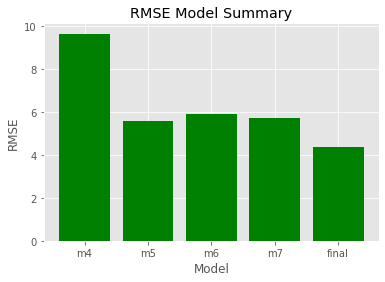

In [59]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")

x = ["m4", "m5", "m6", "m7", "final"]
RMSE = [9.65, 5.58, 5.90, 5.71, 4.36]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, RMSE, color="green")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Model Summary")

plt.xticks(x_pos, x)

plt.show()
plt.show()

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.